In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
import re
import seaborn as sns

# Import Data

In [12]:
url = "https://drive.google.com/uc?id=1nQyZ-krtR2IDxOE4pgU4tIcWPVQz6QTo"
df = pd.read_csv(url)
# drop the first column
df = df.iloc[:, 1:]
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [13]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [14]:
df[df['Clothing ID'].isin([862, 1078, 1094])][['Division Name',	'Department Name',	'Class Name']].value_counts()

,,,count
Division Name,Department Name,Class Name,
General,Dresses,Dresses,1085
General Petite,Dresses,Dresses,695
General,Tops,Knits,487
General Petite,Tops,Knits,319


# EDA

In [15]:
def check_data(dataframe):
    # Check shape
    print(f"Shape: {dataframe.shape}\n")
    print('-' * 50)
    # Check for duplicates
    print(f"Duplicates: {dataframe.duplicated().sum()}\n")
    print('-' * 50)
    # Check for missing values
    print('Missing value')
    df_temp = dataframe.isnull().sum().reset_index()
    df_temp['% missing'] = df_temp.iloc[:, 1] / len(dataframe) * 100
    print(df_temp)
    print('-' * 50)
    # Describe numeric columns
    if not dataframe.select_dtypes(exclude='object').empty:
        print("Descriptive Statistics for Numeric Columns:\n", dataframe.describe(), "\n")
        print('-' * 50)
    # Describ   print('-' * 50)e object (categorical) columns
    if not dataframe.select_dtypes(include='object').empty:
        print("Descriptive Statistics for Categorical Columns:\n", dataframe.describe(include=[object]), "\n")
        print('-' * 50)
    # Check data types
    print("Data Types:\n", dataframe.dtypes, "\n")
    print('-' * 50)
    # Check unique values for each column
    unique_counts = dataframe.nunique()
    print("Unique Values Count:\n", unique_counts, "\n")
    print('-' * 50)
    # Values count
    for col in dataframe.columns:
        print(dataframe[col].value_counts().head())
        print('-' * 30)


In [16]:
check_data(df)

Shape: (23486, 10)

--------------------------------------------------
Duplicates: 21

--------------------------------------------------
Missing value
                     index     0  % missing
0              Clothing ID     0   0.000000
1                      Age     0   0.000000
2                    Title  3810  16.222430
3              Review Text   845   3.597888
4                   Rating     0   0.000000
5          Recommended IND     0   0.000000
6  Positive Feedback Count     0   0.000000
7            Division Name    14   0.059610
8          Department Name    14   0.059610
9               Class Name    14   0.059610
--------------------------------------------------
Descriptive Statistics for Numeric Columns:
         Clothing ID           Age        Rating  Recommended IND  \
count  23486.000000  23486.000000  23486.000000     23486.000000   
mean     918.118709     43.198544      4.196032         0.822362   
std      203.298980     12.279544      1.110031         0.382216

In [17]:
# drop duplicated
df.drop_duplicates(inplace=True)
df.shape

# lower the text
df['Review Text'] = df['Review Text'].str.lower()

In [18]:
err1 = df['Review Text'].str.extractall("(&amp)")
err2 = df['Review Text'].str.extractall("(\xa0)")
print('with &amp',len(err1[~err1.isna()]))
print('with (\xa0)',len(err2[~err2.isna()]))
df['Review Text'] = df['Review Text'].str.replace('(&amp)','')
df['Review Text'] = df['Review Text'].str.replace('(\xa0)','')

with &amp 37
with ( ) 6


# Age, Feedback - Text

[18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88, 93, 98]


<Axes: xlabel='Age_bin', ylabel='Count'>

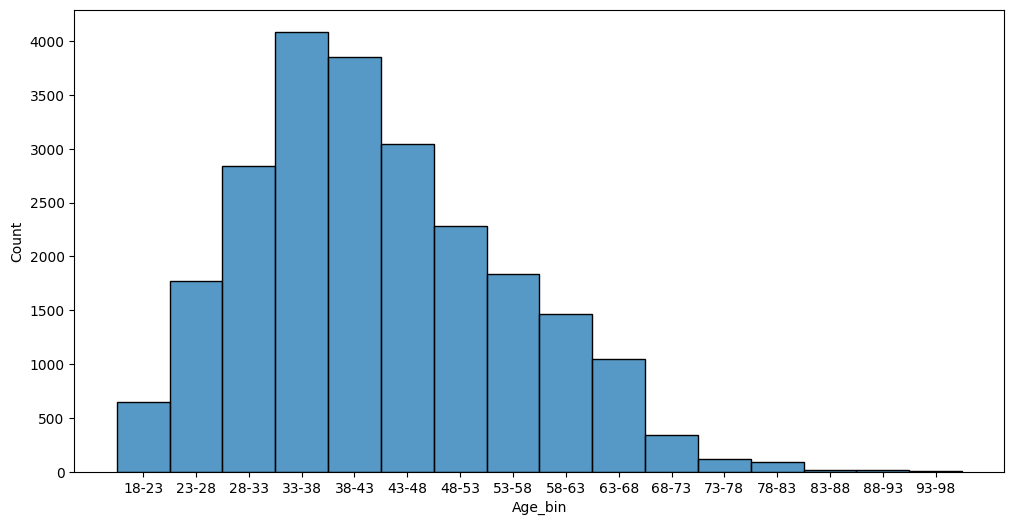

In [19]:
plt.figure(figsize=(12, 6))
bin_list = list(range(18, 101, 5))
label_list = []
for i in range(len(bin_list) - 1):
  label_list.append(str(bin_list[i]) + '-' + str(bin_list[i+1]))

print(bin_list)
label_list
df['Age_bin'] = pd.cut(df['Age'], bins=bin_list, labels=label_list)
sns.histplot(df['Age_bin'])

Review length by age

<ipython-input-21-660e8128bd98>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-21-660e8128bd98>:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0.5, 0.98, "Mean Review's Length by Age")

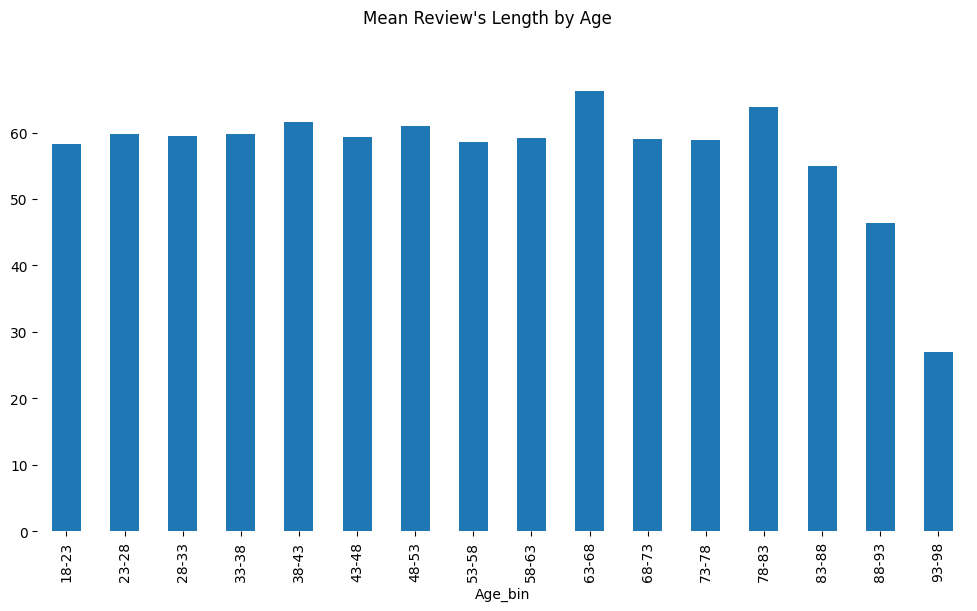

In [21]:
df_temp = df.dropna(subset='Review Text')
plt.figure(figsize=(12, 6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
df_temp['Review_length'] = df_temp['Review Text'].apply(lambda x: len(x.split()))
df_temp.groupby('Age_bin')['Review_length'].mean().plot(kind='bar')
plt.suptitle("Mean Review's Length by Age")

Polarity by age

In [21]:
from textblob import *
import plotly.express as px

<ipython-input-22-63827292701a>:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Text(0.5, 0.98, 'Mean Polarity by Age')

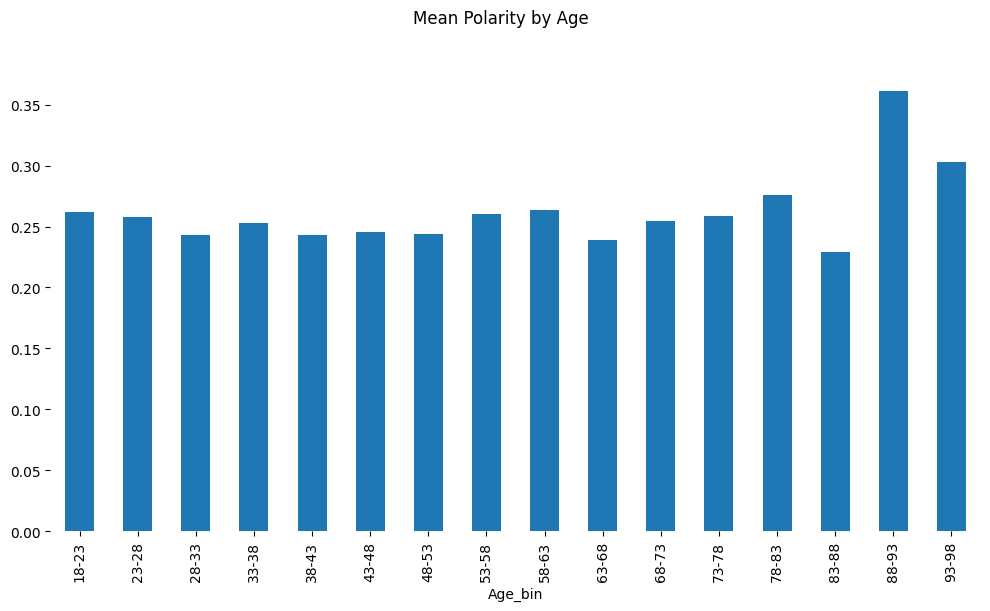

In [22]:
df_temp = df.copy(deep=True)
df_temp.dropna(subset='Review Text', inplace=True)
plt.figure(figsize=(12, 6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
d f_temp['polarity'] = df_temp['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df_temp.groupby('Age_bin')['polarity'].mean().plot(kind='bar')
plt.suptitle("Mean Polarity by Age")

Positive feedback

Text(0.5, 0.98, "Review's length by Positive Feedback Count")

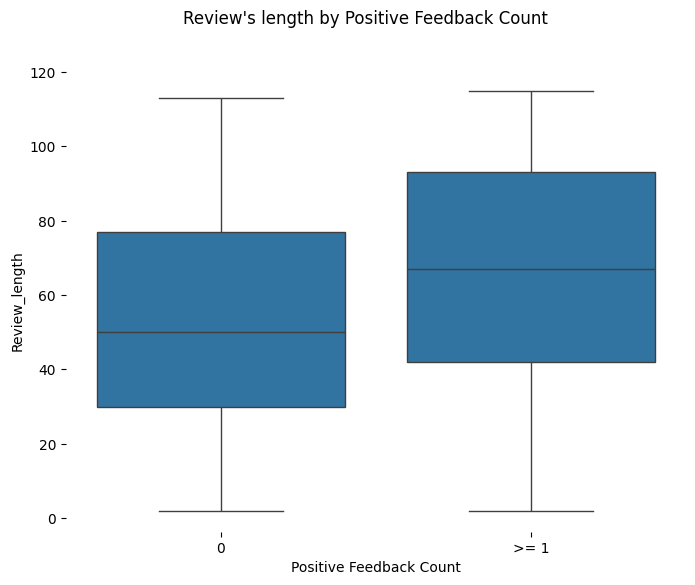

In [9]:
def positive_feedback(x):
  if x == 0: return '0'
  else: return '>= 1'

df_temp = df.copy(deep=True)
df_temp.dropna(subset='Review Text', inplace=True)
plt.figure(figsize=(8, 6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
df_temp['Review_length'] = df_temp['Review Text'].apply(lambda x: len(x.split()))
df_temp['Positive Feedback Count'] = df_temp['Positive Feedback Count'].apply(positive_feedback)
sns.boxplot(x='Positive Feedback Count', y='Review_length', data=df_temp)
plt.suptitle("Review's length by Positive Feedback Count")

In [10]:
df_temp.to_csv('finaldf2.csv')

<Axes: xlabel='Nice_feedback', ylabel='Review_length'>

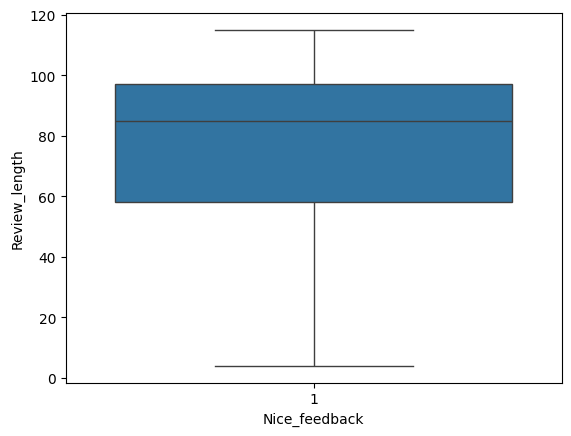

In [ ]:
df_temp = df[df['Positive Feedback Count'] > 10].copy(deep=True)
df_temp.dropna(subset='Review Text', inplace=True)
df_temp['Review_length'] = df_temp['Review Text'].apply(lambda x: len(x.split()))
df_temp['Nice_feedback'] = np.where(df_temp['Positive Feedback Count'] > 0, 1, 0)
sns.boxplot(x='Nice_feedback', y='Review_length', data=df_temp)

# Sentiment Analysis (polarity)

In [8]:
from textblob import *
import plotly.express as px


In [9]:
df_test = df.copy(deep=True)
df_test.dropna(subset='Review Text', inplace=True)

Polarity = 1: Extrame positive

Polarity = -1: Extreme negative

In [53]:
plt.figure(figsize=(10,))
df_test['polarity'] = df_test['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
px.histogram(df_test, x = 'polarity')

TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'float'>

<Figure size 800x600 with 0 Axes>

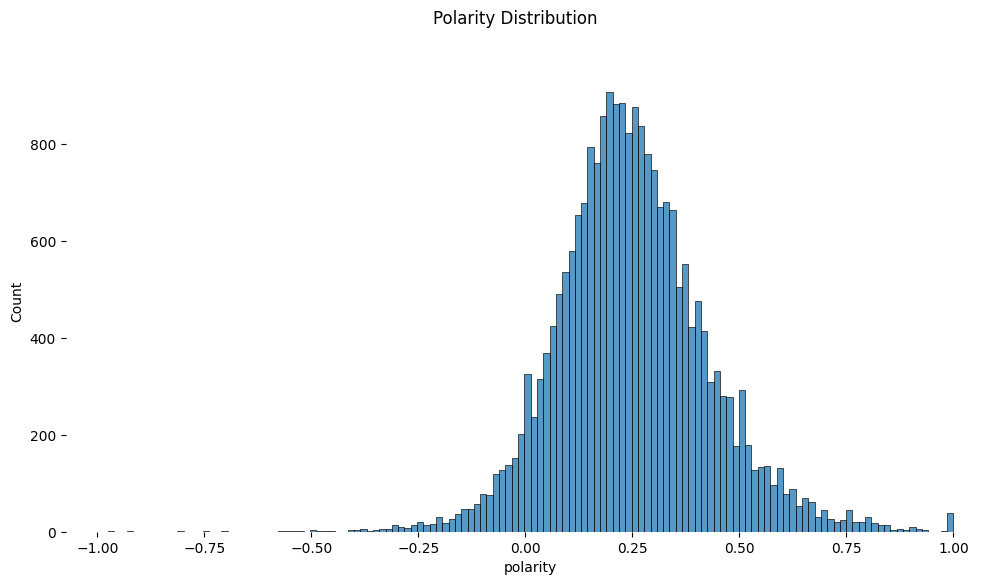

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(df_test['polarity'])
plt.suptitle('Polarity Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

## Polarity by recommended ID

In [ ]:
# sent_pipeline = pipeline('sentiment-analysis')
# token_pipeline = pipeline(model="vblagoje/bert-english-uncased-finetuned-pos", aggregation_strategy="simple")

In [ ]:
# def converting(text):
#   if pd.isna(text): return pd.Series({'Like': [], 'Dislike': []})
#   print(text)
#   conj_list = "But Yet Despite Although However".lower().split()
#   conj_pattern = r'\b(?:' + '|'.join(conj_list) + r')\b|[./;:]'

#   sentences = re.split(conj_pattern, text)
#   sentences = [s.strip() for s in sentences if s.strip()]
#   pos, neg = [], []
#   for stc in sentences:
#     stc_sent = sent_pipeline(stc)[0]
#     stc_token = token_pipeline(stc)
#     for st in stc_token:
#       if st['entity_group'] in ['NOUN']:
#         if stc_sent['label'] == 'POSITIVE': pos.append(st['word'])
#         else: neg.append(st['word'])
#   return pd.Series({'Like': pos, 'Dislike': neg})
# df_status = df_test['Review Text'].apply(converting)

In [ ]:
# like_wc = df_wc[(df_wc['Rating'] >= 4)].explode('Like')['Like'].value_counts().reset_index()
# dislike_wc = df_wc[(df_wc['Rating'] < 3)].explode('Dislike')['Dislike'].value_counts().reset_index()
# like_wc = like_wc[like_wc['Like'].str.len() > 3]
# dislike_wc = dislike_wc[dislike_wc['Dislike'].str.len() > 3]
# like_wc = like_wc.set_index('Like')['count'].to_dict()
# dislike_wc = dislike_wc.set_index('Dislike')['count'].to_dict()

# Title analysis by rating

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud


In [9]:
def top_n_ngram(corpus,n = None,ngram = 1):
    vec = CountVectorizer(stop_words = 'english',ngram_range=(ngram,ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus) #Have the count of  all the words for each review
    sum_words = bag_of_words.sum(axis =0) #Calculates the count of all the word in the whole review
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq[:n]

In [ ]:
col_to_analyze = 'Title'
df_temp = df.copy(deep=True)
df_temp.dropna(subset=col_to_analyze, inplace=True)
# df_temp.shape

pos_df = df_temp[df_temp['Rating'] >= 4]
neg_df = df_temp[df_temp['Rating'] <= 3]

# pos_df = df_temp[df_temp['Recommended IND'] == 1]
# neg_df = df_temp[df_temp['Recommended IND'] == 0]

# pos_df = df_temp[(df_temp['Recommended IND'] == 1) & (df['Positive Feedback Count'] != 0)]
# neg_df = df_temp[(df_temp['Recommended IND'] == 0) & (df['Positive Feedback Count'] != 0)]

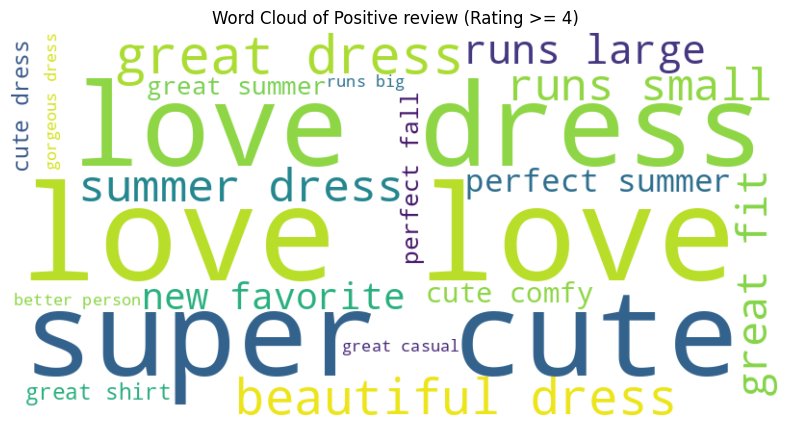

In [ ]:
common_words = top_n_ngram(pos_df[col_to_analyze], 20,2)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of Positive review (Rating >= 4)')
plt.show()


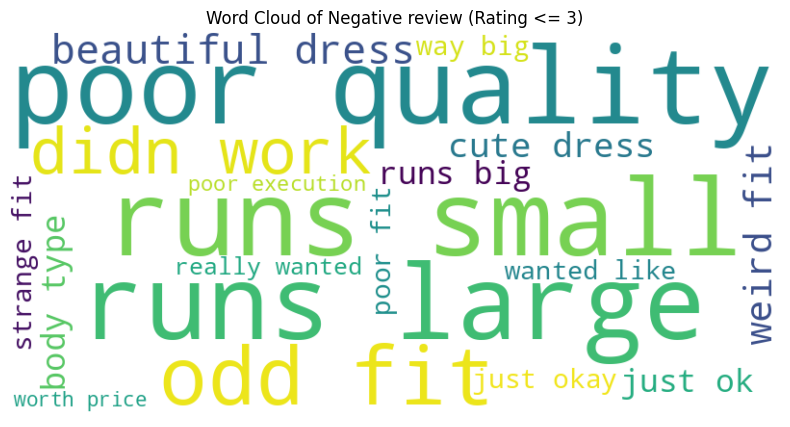

In [ ]:
common_words = top_n_ngram(neg_df[col_to_analyze], 20, 2)[1:]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of Negative review (Rating <= 3)')
plt.show()


# Thematic Analysis

In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('wordnet')
# Importing Gensim
import gensim
from gensim import corpora

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Run

In [ ]:
df_temp = df.groupby('Clothing ID').size().reset_index()
df_temp.columns = ['Clothing ID', 'size']
df_temp2 = pd.merge(df_temp[df_temp['size'] >= 5], df[['Clothing ID', 'Rating']])
df_temp2.groupby('Clothing ID')['Rating'].mean().sort_values()

,Rating
Clothing ID,
569,1.800000
635,2.000000
229,2.181818
946,2.444444
1006,2.600000
...,...
642,5.000000
167,5.000000
506,5.000000


In [ ]:
df['Department Name'].value_counts()

,count
Department Name,
Tops,10455
Dresses,6312
Bottoms,3798
Intimate,1735
Jackets,1032
Trend,119


In [11]:
col_to_analyze = 'Title'
df_test = df.copy(deep=True)
df_test.dropna(subset=col_to_analyze, inplace=True)

# pos_df = df_test[df_test['Rating'] >= 4]
# neg_df = df_test[df_test['Rating'] <= 2]

# use_df = df_test[(df_test['Class Name'].isin(['Knits'])) & (df_test['Rating'] <= 2)]

In [17]:
word_df = pd.DataFrame(columns=['Department', 'Word', 'Count'])
word_df.empty

True

In [24]:
# Sample list of tuples containing words and counts
common_words = [('word1', 10), ('word2', 15), ('word3', 5)]

# Create a DataFrame with 'Word' and 'Count' columns
a = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Add the 'id' column as the first column with a value of 1
a

# Display the DataFrame
print(a)

   id   Word  Count
0   1  word1     10
1   1  word2     15
2   1  word3      5


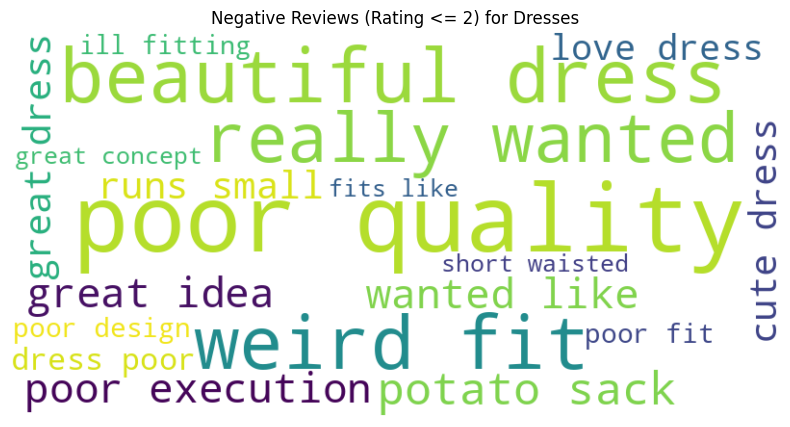

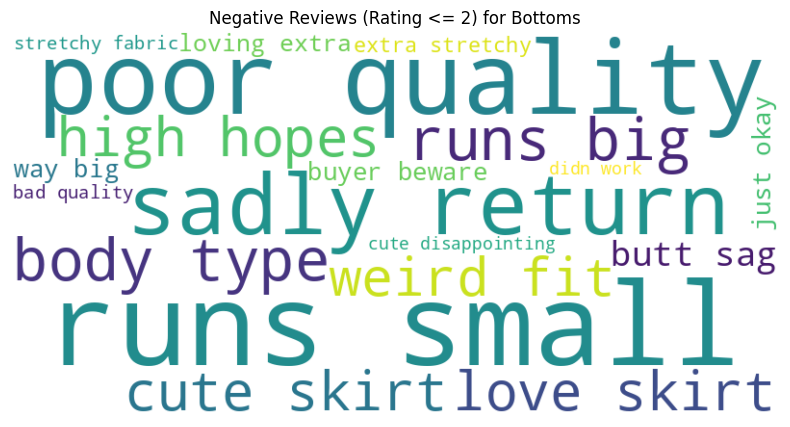

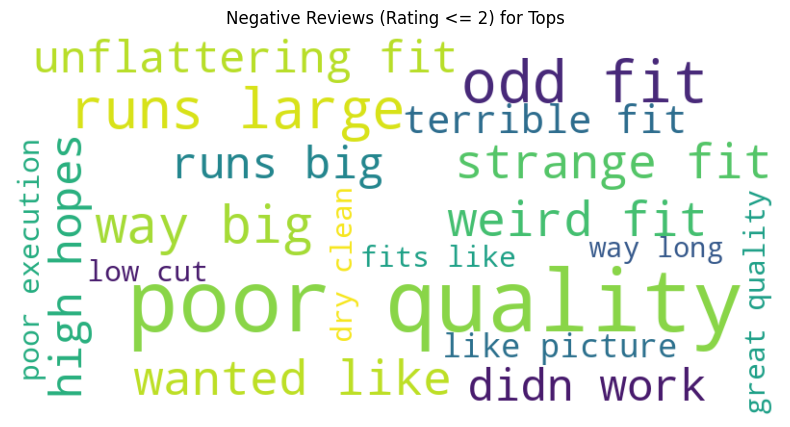

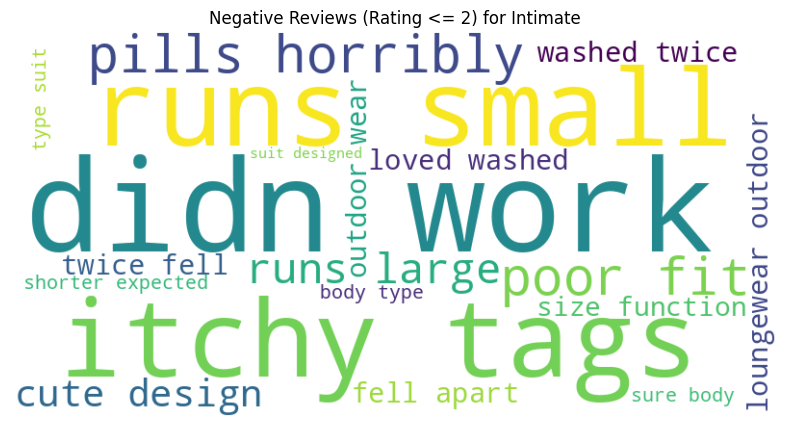

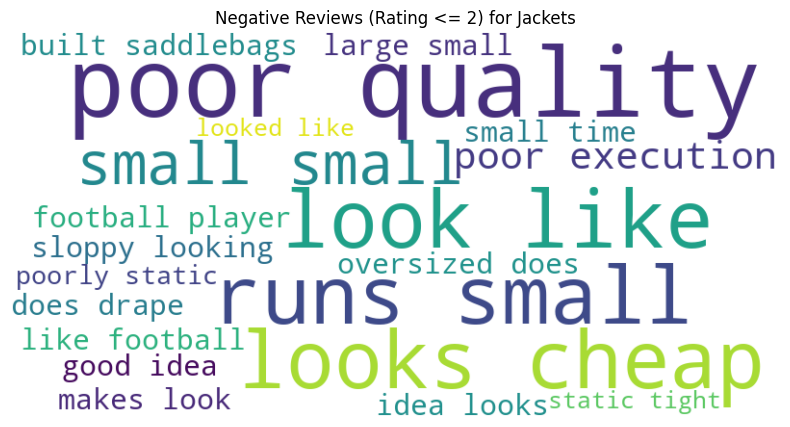

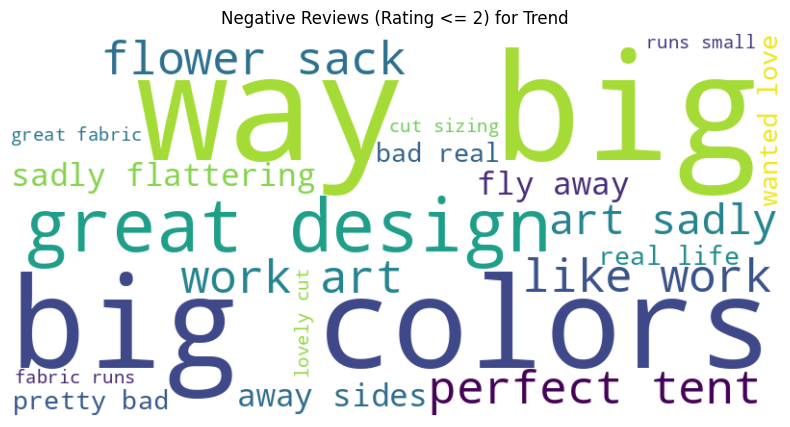

In [39]:
word_df = pd.DataFrame(columns=['Department', 'Word', 'Count'])
for clothing_type in df_test['Department Name'].unique():
  use_df = df_test[(df_test['Department Name'] == clothing_type) & (df_test['Rating'] <= 2)]

  if not use_df.empty:
    # Generate the common words for the 'col_to_analyze' (e.g., 'Review Text')
    common_words = top_n_ngram(use_df[col_to_analyze], 20, 2)
    if common_words[0][0] == 'wanted love': common_words = common_words[1:]
    temp_df = pd.DataFrame()
    temp_df[['Word', 'Count']] = pd.DataFrame(common_words, columns=['Word', 'Count'])
    temp_df.insert(0, 'Department', clothing_type)
    temp_df.insert(0, 'Rating', rating)
    word_df = pd.concat([word_df, temp_df], ignore_index=True)
    # common_words = common_words[1:]
    # Generate the word cloud from the common words
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axis
    plt.title(f'Negative Reviews (Rating <= 2) for {clothing_type}')
    plt.show()

In [38]:
word_df

,Department,Word,Count,Rating
0,Dresses,beautiful dress,22,3.0
1,Dresses,cute dress,18,3.0
2,Dresses,runs large,16,3.0
3,Dresses,wanted love,15,3.0
4,Dresses,runs small,15,3.0
...,...,...,...,...
570,Jackets,massive unflattering,1,1.0
571,Trend,perfect tent,1,1.0
572,Trend,pretty bad,1,1.0
573,Trend,bad real,1,1.0


In [37]:
word_df.to_csv('word_df.csv')

In [ ]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = use_df[col_to_analyze].apply(clean)

In [ ]:
doc_clean = doc_clean.str.split().to_list()

In [ ]:

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

In [ ]:
topics = ldamodel.print_topics(num_topics=10, num_words=3)
print(topics)


[(0, '0.059*"pretty" + 0.048*"small" + 0.042*"huge"'), (1, '0.082*"fit" + 0.065*"beautiful" + 0.048*"color"'), (2, '0.069*"love" + 0.061*"cute" + 0.047*"wanted"'), (3, '0.067*"top" + 0.048*"fabric" + 0.047*"great"'), (4, '0.053*"short" + 0.048*"large" + 0.039*"boxy"')]


In [ ]:
topics

[(0, '0.059*"pretty" + 0.048*"small" + 0.042*"huge"'),
 (1, '0.082*"fit" + 0.065*"beautiful" + 0.048*"color"'),
 (2, '0.069*"love" + 0.061*"cute" + 0.047*"wanted"'),
 (3, '0.067*"top" + 0.048*"fabric" + 0.047*"great"'),
 (4, '0.053*"short" + 0.048*"large" + 0.039*"boxy"')]

In [ ]:


# Vectorize the text
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
text_vectorized = vectorizer.fit_transform(use_df[col_to_analyze])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(text_vectorized)

# Display topics
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}: ", [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-5:]])


Topic 0:  ['pictured', 'like', 'fabric', 'wanted', 'love']
Topic 1:  ['arms', 'shrunk', 'cheap', 'great', 'big']
Topic 2:  ['sheer', 'unflattering', 'color', 'fit', 'beautiful']
Topic 3:  ['sizing', 'colors', 'nice', 'sleeves', 'disappointing']
Topic 4:  ['flattering', 'disappointed', 'poor', 'boxy', 'quality']
Topic 5:  ['fits', 'lovely', 'maternity', 'runs', 'large']
Topic 6:  ['color', 'fit', 'huge', 'wide', 'weird']
Topic 7:  ['beautiful', 'runs', 'blouse', 'small', 'cute']
Topic 8:  ['cut', 'odd', 'strange', 'fit', 'pretty']
Topic 9:  ['boxy', 'beautiful', 'sad', 'way', 'short']


In [ ]:
# # All product
# Topic 0:  ['color', 'blouse', 'comfy', 'flattering', 'beautiful']
# Topic 1:  ['feminine', 'skirt', 'gorgeous', 'nice', 'pretty']
# Topic 2:  ['stylish', 'comfy', 'sweater', 'super', 'cute']
# Topic 3:  ['good', 'big', 'runs', 'small', 'lovely']
# Topic 4:  ['staple', 'fun', 'summer', 'great', 'dress']
# Topic 5:  ['piece', 'fall', 'great', 'perfect', 'love']
# Topic 6:  ['person', 'size', 'fabric', 'great', 'shirt']
# Topic 7:  ['pants', 'great', 'soft', 'comfortable', 'fit']
# Topic 8:  ['great', 'favorite', 'style', 'design', 'versatile']
# Topic 9:  ['just', 'tee', 'adorable', 'unique', 'large']

In [ ]:
# Bestseller
# Topic 0:  ['perfect', 'comfortable', 'size', 'love', 'dress']
# Topic 1:  ['really', 'fit', 'just', 'like', 'dress']
# Topic 2:  ['body', 'ordered', 'wear', 'fabric', 'dress']
# Topic 3:  ['just', 'nice', 'fabric', 'like', 'dress']
# Topic 4:  ['color', 'look', 'love', 'fit', 'dress']
# Topic 5:  ['fit', 'bust', 'fabric', 'waist', 'dress']
# Topic 6:  ['fit', 'wear', 'size', 'love', 'dress']
# Topic 7:  ['petite', 'ordered', 'length', 'great', 'dress']
# Topic 8:  ['just', 'regular', 'great', 'size', 'dress']
# Topic 9:  ['size', 'cute', 'great', 'slip', 'dress']

In [ ]:
Blouses: size, quality

# ABSA

In [ ]:
from transformers import pipeline
aspect_sentiment_pipeline = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df_test = df.copy(deep=True)
df_test.dropna(subset='Review Text', inplace=True)

In [ ]:
pos_df = df_test[df_test['Rating'] >= 4]
neg_df = df_test[df_test['Rating'] <= 3]

use_df = neg_df

In [ ]:
def aspect_sentiment_analysis(review, aspects):
    results = {}
    for aspect in aspects:
        if aspect in review.lower():
            sentiment_result = aspect_sentiment_pipeline(review)
            results[aspect] = sentiment_result[0]['label']  # Extract sentiment label (e.g., POSITIVE, NEGATIVE)
    return results


aspects = ['fabric', 'color', 'size', 'material', 'stitching', 'tight', 'small', 'large', 'material']

# Apply function to each review
use_df['Aspect Sentiments'] = use_df['Review Text'].apply(lambda x: aspect_sentiment_analysis(x, aspects))

# Display results
print(use_df[['Review Text', 'Aspect Sentiments']])


                                             Review Text  \
2      i had such high hopes for this dress and reall...   
5      i love tracy reese dresses, but this one is no...   
10     dress runs small esp where the zipper area run...   
14     this is a nice choice for holiday gatherings. ...   
16     material and color is nice.  the leg opening i...   
...                                                  ...   
23475  cute dress but not for me.  the waist is too h...   
23478  i was surprised at the positive reviews for th...   
23482  it reminds me of maternity clothes. soft, stre...   
23483  this fit well, but the top was very see throug...   
23484  i bought this dress for a wedding i have this ...   

                                       Aspect Sentiments  
2      {'size': '3 stars', 'tight': '3 stars', 'small...  
5               {'color': '2 stars', 'small': '2 stars'}  
10     {'fabric': '2 stars', 'material': '2 stars', '...  
14     {'fabric': '3 stars', 'size': '3 sta

<ipython-input-12-f99acf965d9e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_df['Aspect Sentiments'] = use_df['Review Text'].apply(lambda x: aspect_sentiment_analysis(x, aspects))
